# Visualização de Clusters Fuzzy
Adaptação do código para plotar clusters fuzzy usando dados de throughput e utilização de PRB

In [2]:
# Importar bibliotecas
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import skfuzzy as fuzz
from sklearn.metrics import silhouette_score
import re
from sklearn.metrics import silhouette_samples, silhouette_score
import numpy as np
import skfuzzy as fuzz
import matplotlib.pyplot as plt

In [3]:
# Carregar o dataset
file_path = "data/df_agrupamentofuzzy_3.csv"
df = pd.read_csv(file_path)
num_cols = df.select_dtypes(include="number").columns

# remover colunas de pertinência e cluster
num_cols = [c for c in num_cols if not c.startswith("pertinencia_") and c != "cluster_fuzzy"]

X_loaded = df[num_cols].to_numpy()   # (n_samples, n_features)
X_loaded_T = X_loaded.T                  # (n_features, n_samples)

print("Hash X lido:", hash(X_loaded.tobytes()))

Hash X lido: -3280729262404096627


In [4]:
X_loaded

array([[5.00000000e+01, 4.54400000e+00, 4.18020513e+03, 6.86500000e+00,
        2.26689594e+05, 2.07852999e+05],
       [5.00000000e+01, 5.39800000e+00, 7.40668741e+03, 6.73600000e+00,
        3.71498004e+05, 3.33790556e+05],
       [5.00000000e+01, 4.31600000e+00, 1.49922353e+03, 5.40800000e+00,
        9.27564150e+04, 8.04179639e+04],
       ...,
       [5.00000000e+01, 6.61600000e+00, 2.45075261e+04, 4.84400000e+00,
        3.48986672e+05, 3.24642206e+05],
       [5.00000000e+01, 6.90000000e+00, 4.32025757e+04, 1.72810000e+01,
        5.37333432e+05, 4.77212603e+05],
       [5.00000000e+01, 4.53200000e+00, 3.31885582e+04, 4.08500000e+00,
        1.07371625e+05, 9.50640010e+04]], shape=(20172, 6))

In [5]:
colunas_pertinencia = [c for c in df.columns if re.match(r'pertinencia_cluster_\d+', c)]
colunas_cluster = [c for c in df.columns if c == 'cluster_fuzzy']
colunas_remover = colunas_pertinencia + colunas_cluster
colunas_sobraram = [c for c in df.columns if c not in colunas_remover]
colunas_features = [
    c for c in colunas_sobraram if df[c].dtype in ['int64', 'float64']
]

In [6]:
colunas_pertinencia

['pertinencia_cluster_0', 'pertinencia_cluster_1', 'pertinencia_cluster_2']

In [7]:
cluster_col = "cluster_fuzzy"

# Contar número de pessoas em cada cluster
cluster_counts = df[cluster_col].value_counts().sort_index()  # ordena por cluster
print("Número de pessoas em cada cluster:")
print(cluster_counts)

Número de pessoas em cada cluster:
cluster_fuzzy
0    6957
1    3534
2    9681
Name: count, dtype: int64


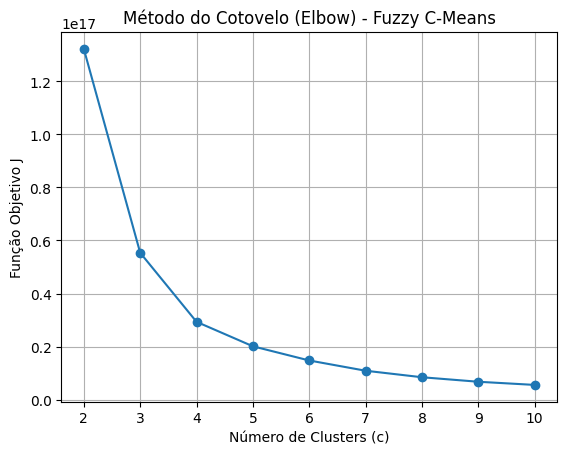

In [8]:
X= X_loaded_T

clusters_range = range(2, 11)
objectives = []

for c in clusters_range:
    cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
        X, c=c, m=2, error=0.0001, maxiter=1000
    )

    objectives.append(jm[-1]) 

plt.plot(clusters_range, objectives, marker='o')
plt.xlabel("Número de Clusters (c)")
plt.ylabel("Função Objetivo J")
plt.title("Método do Cotovelo (Elbow) - Fuzzy C-Means")
plt.grid(True)
plt.show()

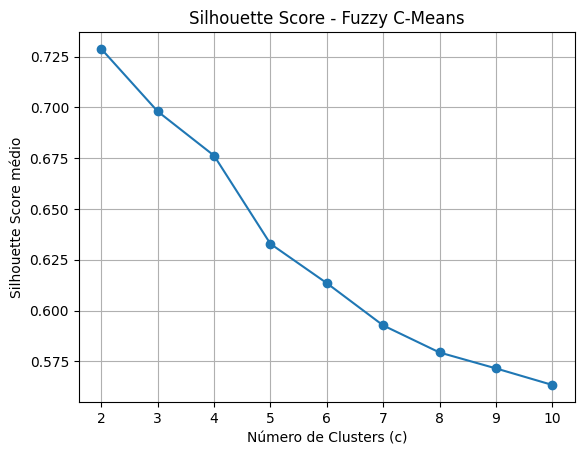

In [9]:
clusters_range = range(2, 11)
silhouette_scores = []
avg_silhouettes = {}
for c in clusters_range:
    # Rodar FCMA
    cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
        X, c=c, m=2, error=0.0001, maxiter=1000
    )

    # Transformar particionamento fuzzy em labels crisp
    labels = np.argmax(u, axis=0)

    # Silhueta precisa dos pontos em formato (n_samples, n_features)
    X_transposed = X.T

    # Calcular score médio
    score = silhouette_score(X_transposed, labels)
    silhouette_scores.append(score)

    # Silhueta individual por ponto
    sample_sil = silhouette_samples(X_transposed, labels)
    avg_silhouettes[c] = sample_sil

# Plot do método do cotovelo para silhueta
plt.plot(clusters_range, silhouette_scores, marker='o')
plt.xlabel("Número de Clusters (c)")
plt.ylabel("Silhouette Score médio")
plt.title("Silhouette Score - Fuzzy C-Means")
plt.grid(True)
plt.show()


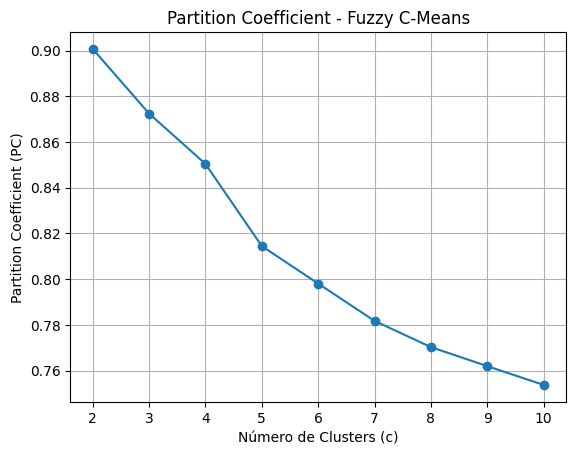

In [10]:
def partition_coefficient(u):
    c, n = u.shape
    return (u**2).sum() / n

clusters_range = range(2, 11)
pcs = []

for c in clusters_range:
    cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
        X, c=c, m=2, error=0.001, maxiter=1000
    )

    pc = partition_coefficient(u)
    pcs.append(pc)

   

plt.plot(clusters_range, pcs, marker='o')
plt.xlabel("Número de Clusters (c)")
plt.ylabel("Partition Coefficient (PC)")
plt.title("Partition Coefficient - Fuzzy C-Means")
plt.grid(True)
plt.show()

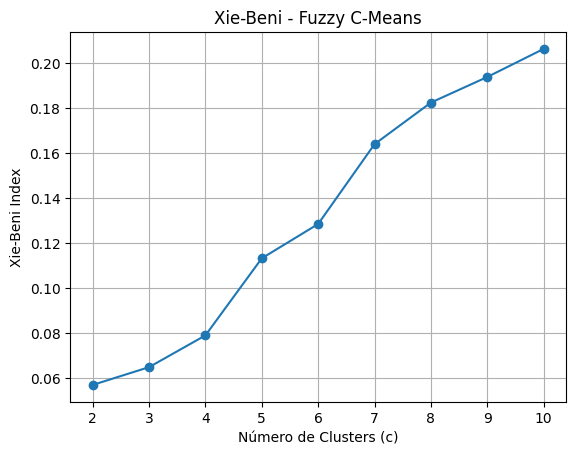

In [11]:
def xie_beni_index(X, u, centers):
    """
    X : array (n_samples, n_features)
    u : matrix de pertinência (c, n_samples)
    centers : array (c, n_features)
    """

    c, n = u.shape
    
    # Distância quadrática de cada ponto para cada centro
    dist_sq = np.zeros((c, n))
    for i in range(c):
        dist_sq[i] = np.sum((X - centers[i])**2, axis=1)

    # Numerador: soma ponderada fuzzy das distâncias
    numerator = np.sum(u**2 * dist_sq)

    # Denominador: menor distância entre centros
    min_center_dist = np.inf
    for i in range(c):
        for j in range(i+1, c):
            d = np.sum((centers[i] - centers[j])**2)
            min_center_dist = min(min_center_dist, d)

    return numerator / (n * min_center_dist)


# ----------- Rodar XB para vários valores de c -----------

clusters_range = range(2, 11)
xb_values = []

# X deve estar como (n_samples, n_features)
X_np = X.T  

for c in clusters_range:
    cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
        X, c=c, m=2, error=0.001, maxiter=1000
    )

    xb = xie_beni_index(X_np, u, cntr)
    xb_values.append(xb)


# ------------ Plot do Xie-Beni ------------
plt.plot(clusters_range, xb_values, marker='o')
plt.xlabel("Número de Clusters (c)")
plt.ylabel("Xie-Beni Index")
plt.title("Xie-Beni - Fuzzy C-Means")
plt.grid(True)
plt.show()

## DBSCAN

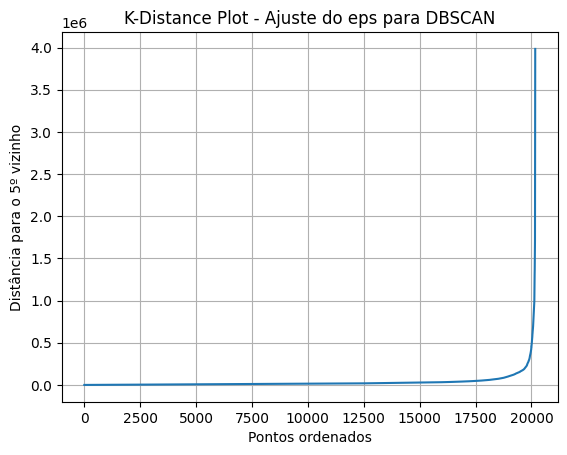

In [12]:

from sklearn.neighbors import NearestNeighbors

X = X_loaded

k = 5  # mesmo valor que você vai usar como min_samples no DBSCAN

neighbors = NearestNeighbors(n_neighbors=k)
neighbors.fit(X)

distances, indices = neighbors.kneighbors(X)

# Distância até o k-ésimo vizinho
k_distances = np.sort(distances[:, k-1])

plt.plot(k_distances)
plt.xlabel("Pontos ordenados")
plt.ylabel(f"Distância para o {k}º vizinho")
plt.title("K-Distance Plot - Ajuste do eps para DBSCAN")
plt.grid(True)
plt.show()

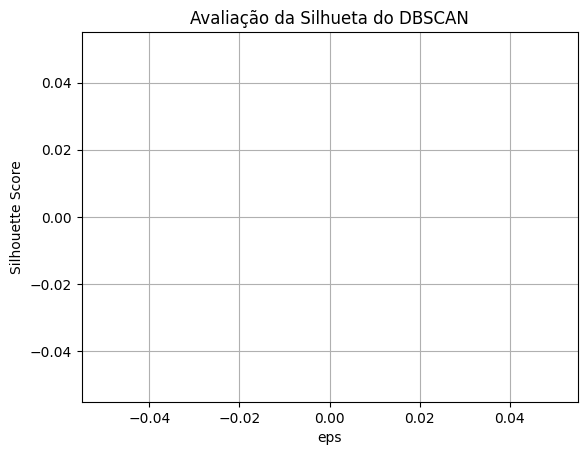

In [26]:
from sklearn.cluster import DBSCAN

X = X_loaded  

eps_values = np.linspace(0.01, 0.5, 50)
silhouette_scores = []

for eps in eps_values:
    dbscan = DBSCAN(eps=eps, min_samples=5)
    labels = dbscan.fit_predict(X)

    mask = labels != -1  
    X_valid = X[mask]
    labels_valid = labels[mask]

    if len(np.unique(labels_valid)) > 1:
        score = silhouette_score(X_valid, labels_valid)
        silhouette_scores.append(score)
    else:
        silhouette_scores.append(np.nan)

plt.plot(eps_values, silhouette_scores)
plt.xlabel("eps")
plt.ylabel("Silhouette Score")
plt.title("Avaliação da Silhueta do DBSCAN")
plt.grid(True)
plt.show()


In [24]:
for eps in np.linspace(0.5, 3.0, 30):
    dbscan = DBSCAN(eps=eps, min_samples=3)  # reduzindo min_samples
    labels = dbscan.fit_predict(X)

    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = list(labels).count(-1)

    print(f"eps={eps:.2f} → clusters={n_clusters}, ruído={n_noise}")


eps=0.50 → clusters=0, ruído=20172
eps=0.59 → clusters=0, ruído=20172
eps=0.67 → clusters=0, ruído=20172
eps=0.76 → clusters=0, ruído=20172
eps=0.84 → clusters=0, ruído=20172
eps=0.93 → clusters=0, ruído=20172
eps=1.02 → clusters=0, ruído=20172
eps=1.10 → clusters=0, ruído=20172
eps=1.19 → clusters=0, ruído=20172
eps=1.28 → clusters=0, ruído=20172
eps=1.36 → clusters=0, ruído=20172
eps=1.45 → clusters=0, ruído=20172
eps=1.53 → clusters=0, ruído=20172
eps=1.62 → clusters=0, ruído=20172
eps=1.71 → clusters=0, ruído=20172
eps=1.79 → clusters=0, ruído=20172
eps=1.88 → clusters=0, ruído=20172
eps=1.97 → clusters=0, ruído=20172
eps=2.05 → clusters=0, ruído=20172
eps=2.14 → clusters=0, ruído=20172
eps=2.22 → clusters=0, ruído=20172
eps=2.31 → clusters=0, ruído=20172
eps=2.40 → clusters=0, ruído=20172
eps=2.48 → clusters=0, ruído=20172
eps=2.57 → clusters=0, ruído=20172
eps=2.66 → clusters=0, ruído=20172
eps=2.74 → clusters=0, ruído=20172
eps=2.83 → clusters=0, ruído=20172
eps=2.91 → clusters=